In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import sklearn
import sys
import tensorflow as tf
import time
import random
import pathlib

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


training_path = pathlib.Path('./training')
validation_path = pathlib.Path('./valid')

train_image_paths = list(training_path.glob('*/*'))  
valid_image_paths = list(validation_path.glob('*/*'))  

train_image_paths = [str(path) for path in train_image_paths]
valid_image_paths = [str(path) for path in valid_image_paths]

random.shuffle(train_image_paths)
random.shuffle(valid_image_paths)
train_image_count = len(train_image_paths)
valid_image_count = len(valid_image_paths)

print("Training Images -> ", train_image_count)
print("Validation Images -> ", valid_image_count)

2.0.0
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
numpy 1.16.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf
Training Images ->  1339
Validation Images ->  10


In [2]:
train_image_paths[:5]

['training\\tether\\eD71E8422D.png',
 'training\\eos\\32DC6ceff1.png',
 'training\\xml\\FC41B2dbA4 - 副本 (4).png',
 'training\\litecoin\\a22FfEac3d - 副本 (8).png',
 'training\\xml\\4929378bEd - 副本 (10).png']

In [3]:
valid_image_paths[:5]

['valid\\eos\\coinflip_item_eos.png',
 'valid\\binance\\coinflip_item_binance.png',
 'valid\\tether\\coinflip_item_tether.png',
 'valid\\rlt\\coinflip_item_rlt.png',
 'valid\\litecoin\\coinflip_item_litecoin.png']

In [4]:
label_names = sorted(item.name for item in training_path.glob('*/') if item.is_dir())
label_names

['binance',
 'btc',
 'eos',
 'eth',
 'litecoin',
 'monero',
 'rlt',
 'tether',
 'xml',
 'xrp']

In [5]:
training_image_labels = [pathlib.Path(path).parent.name for path in train_image_paths]
for image, label in zip(train_image_paths[:5], training_image_labels[:5]):
    print(image, ' --->  ', label)

training\tether\eD71E8422D.png  --->   tether
training\eos\32DC6ceff1.png  --->   eos
training\xml\FC41B2dbA4 - 副本 (4).png  --->   xml
training\litecoin\a22FfEac3d - 副本 (8).png  --->   litecoin
training\xml\4929378bEd - 副本 (10).png  --->   xml


In [6]:
train_labels_info = []
for image_path, label in zip(train_image_paths, training_image_labels):
    train_labels_info.append((image_path, label))

In [7]:
import pprint
pprint.pprint(train_labels_info[:5])

[('training\\tether\\eD71E8422D.png', 'tether'),
 ('training\\eos\\32DC6ceff1.png', 'eos'),
 ('training\\xml\\FC41B2dbA4 - 副本 (4).png', 'xml'),
 ('training\\litecoin\\a22FfEac3d - 副本 (8).png', 'litecoin'),
 ('training\\xml\\4929378bEd - 副本 (10).png', 'xml')]


In [8]:
valid_image_labels = [pathlib.Path(path).parent.name for path in valid_image_paths]
for image, label in zip(valid_image_paths[:5], valid_image_labels[:5]):
    print(image, ' --->  ', label)

valid\eos\coinflip_item_eos.png  --->   eos
valid\binance\coinflip_item_binance.png  --->   binance
valid\tether\coinflip_item_tether.png  --->   tether
valid\rlt\coinflip_item_rlt.png  --->   rlt
valid\litecoin\coinflip_item_litecoin.png  --->   litecoin


In [9]:
valid_labels_info = []
for image_path, label in zip(valid_image_paths, valid_image_labels):
    valid_labels_info.append((image_path, label))

In [10]:
pprint.pprint(valid_labels_info[:5])

[('valid\\eos\\coinflip_item_eos.png', 'eos'),
 ('valid\\binance\\coinflip_item_binance.png', 'binance'),
 ('valid\\tether\\coinflip_item_tether.png', 'tether'),
 ('valid\\rlt\\coinflip_item_rlt.png', 'rlt'),
 ('valid\\litecoin\\coinflip_item_litecoin.png', 'litecoin')]


In [11]:
train_df = pd.DataFrame(train_labels_info)
valid_df = pd.DataFrame(valid_labels_info)

train_df.columns = valid_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())

                                    filepath     class
0             training\tether\eD71E8422D.png    tether
1                training\eos\32DC6ceff1.png       eos
2       training\xml\FC41B2dbA4 - 副本 (4).png       xml
3  training\litecoin\a22FfEac3d - 副本 (8).png  litecoin
4      training\xml\4929378bEd - 副本 (10).png       xml
                                    filepath     class
0            valid\eos\coinflip_item_eos.png       eos
1    valid\binance\coinflip_item_binance.png   binance
2      valid\tether\coinflip_item_tether.png    tether
3            valid\rlt\coinflip_item_rlt.png       rlt
4  valid\litecoin\coinflip_item_litecoin.png  litecoin


In [18]:
height = 139
width = 128
channels = 3
batch_size = 10
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    #像素值 都除以255
    rescale = 1./255,
    # 图片左右位移  20%限度以内
    width_shift_range = 0.2,
    # 图片上下位移  20%限度以内
    height_shift_range = 0.2,
    # 图像剪切强度
    shear_range = 0.2,
    # 图像缩放强度
    zoom_range = 0.2,
    # 是否水平翻转
    horizontal_flip = False,
    # 放大缩小吼， 像素填充方式
    fill_mode = 'nearest',
)

train_generator = train_datagen.flow_from_dataframe(train_df, directory = './',
                                                    x_col = 'filepath',
                                                    y_col = 'class',
                                                    classes = label_names,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 2333,
                                                    shuffle = True,
                                                    class_mode = "categorical")

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)
valid_generator = valid_datagen.flow_from_dataframe(valid_df, directory = './',
                                                    x_col = 'filepath',
                                                    y_col = 'class',
                                                    classes = label_names,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 666,
                                                    shuffle = True,
                                                    class_mode = "categorical")


Found 1339 validated image filenames belonging to 10 classes.
Found 10 validated image filenames belonging to 10 classes.


In [19]:
train_num = train_generator.samples
valid_num = valid_generator.samples

print("Training Generator Sample -> ", train_num)
print("Validation Generator Sample -> ", valid_num)

Training Generator Sample ->  1339
Validation Generator Sample ->  10


In [20]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(10, 139, 128, 3) (10, 10)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(10, 139, 128, 3) (10, 10)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [21]:
model = keras.models.Sequential([
     
    keras.layers.Conv2D(filters=4, kernel_size = 3, padding='same',
                       activation = 'selu', input_shape = [height, width, channels]),
    keras.layers.Conv2D(filters=4, kernel_size = 3, 
                        padding='same', activation = 'selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=8, kernel_size = 3, 
                        padding='same', activation = 'selu'),
    keras.layers.Conv2D(filters=8, kernel_size = 3, 
                        padding='same', activation = 'selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=16, kernel_size = 3, padding='same',
                       activation = 'selu', input_shape = [height, width, channels]),
    keras.layers.Conv2D(filters=16, kernel_size = 3, 
                        padding='same', activation = 'selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation = 'selu'),
    keras.layers.AlphaDropout(rate=0.5),
    
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(loss="categorical_crossentropy",
             optimizer = "adam", metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 139, 128, 4)       112       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 139, 128, 4)       148       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 69, 64, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 69, 64, 8)         296       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 69, 64, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 32, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 32, 16)       

In [22]:
logdir = './coin_recognition'
if not os.path.exists(logdir):
    os.mkdir(logdir)

output_model_file = os.path.join(logdir, "coin_recognition_model.h5")

callbacks = [
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

In [23]:
epochs = 100
#因为数据是generator 产生的 所以不能用fit函数
history = model.fit_generator(train_generator, steps_per_epoch=train_num // batch_size,
                             epochs=epochs, validation_data=valid_generator,
                             validation_steps=valid_num//batch_size)

Epoch 1/100
133/133 [==============================] - 9s 67ms/step - loss: 1.5665 - accuracy: 0.4560 - val_loss: 0.0814 - val_accuracy: 1.0000
Epoch 2/100
133/133 [==============================] - 10s 72ms/step - loss: 0.7132 - accuracy: 0.7351 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 3/100
133/133 [==============================] - 9s 68ms/step - loss: 0.4556 - accuracy: 0.8345 - val_loss: 0.1138 - val_accuracy: 0.9000
Epoch 4/100
133/133 [==============================] - 9s 68ms/step - loss: 0.4182 - accuracy: 0.8382 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 5/100
133/133 [==============================] - 9s 69ms/step - loss: 0.5159 - accuracy: 0.8239 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/100
133/133 [==============================] - 9s 68ms/step - loss: 0.7094 - accuracy: 0.7502 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 7/100
133/133 [==============================] - 9s 67ms/step - loss: 0.2460 - accuracy: 0.9142 - val_loss: 3.5305e-04 - val_accu

133/133 [==============================] - 9s 67ms/step - loss: 0.2336 - accuracy: 0.9202 - val_loss: 1.1109e-04 - val_accuracy: 1.0000
Epoch 57/100
133/133 [==============================] - 9s 67ms/step - loss: 0.1514 - accuracy: 0.9495 - val_loss: 1.0491e-05 - val_accuracy: 1.0000
Epoch 58/100
133/133 [==============================] - 9s 68ms/step - loss: 0.1112 - accuracy: 0.9601 - val_loss: 5.2096e-06 - val_accuracy: 1.0000
Epoch 59/100
133/133 [==============================] - 9s 69ms/step - loss: 0.1738 - accuracy: 0.9503 - val_loss: 9.2153e-06 - val_accuracy: 1.0000
Epoch 60/100
133/133 [==============================] - 9s 67ms/step - loss: 0.1782 - accuracy: 0.9571 - val_loss: 2.0041e-05 - val_accuracy: 1.0000
Epoch 61/100
133/133 [==============================] - 9s 66ms/step - loss: 0.1690 - accuracy: 0.9481 - val_loss: 2.6051e-05 - val_accuracy: 1.0000
Epoch 62/100
133/133 [==============================] - 9s 68ms/step - loss: 0.1796 - accuracy: 0.9466 - val_loss: 1.34

In [24]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_' + label]
    
    pd.DataFrame(data).plot(figsize = (8,5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

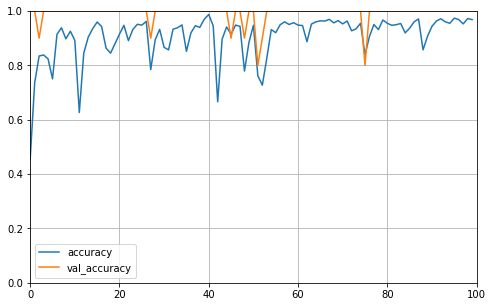

In [25]:
plot_learning_curves(history, 'accuracy', epochs, 0, 1)

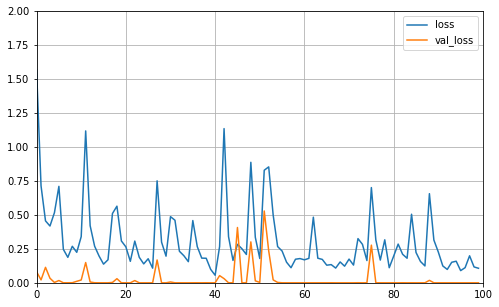

In [26]:
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [33]:
def load_and_preprocess_single_img(path):
    # read the img through file path
    image = tf.io.read_file(path)  
    image = tf.image.decode_jpeg(image, channels=3)
    # 原始图片大小为(139, 128, 3)，重设为(139,128)
    image = tf.image.resize(image, [139, 128])  
    image = tf.cast(image, tf.float32) / 255.0  # 归一化到[0,1]范围
    image = np.expand_dims(image, axis = 0) # since you have batch_size, so you need to expand your image
    return image

In [34]:
def evaluate_single_pic(path, show=False):
    
    if show:
        import matplotlib.image as mpimg
        plt.imshow(mpimg.imread(path))
    image = load_and_preprocess_single_img(path)
    predict_result = model.predict(image)
    print("This is", label_names[np.argmax(predict_result, axis=1)[0]])

In [27]:
model.save_weights('./checkpoints/my_checkpoint')

In [28]:
model.save('./coin_recognition_model.h5')

This is eth


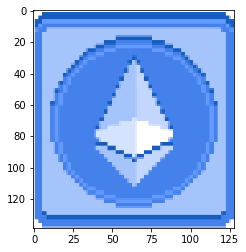

In [36]:
test_pic_path2 = "./test/tt3.png"
evaluate_single_pic(test_pic_path2, True)